In [1]:
# !pip install requests beautifulsoup4

### **Crawl q&a data**

#### **Get link**

In [25]:
import requests
from bs4 import BeautifulSoup

def get_article_links(type, q, page=1):
    url = f"https://thuvienphapluat.vn/hoi-dap-phap-luat/tim-tu-van?searchType={type}&q={q}&searchField=1&page={page}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Không thể truy cập trang web")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    links = []

    
    for info in soup.select("article"):  # Chọn thẻ <article> của danh sách bài viết
        link = info.select_one('a.title-link')
        href = link.get("href")
        title = link.get("title")
        question = info.select_one('div.line-clamp-3').text.strip()
        date = info.select_one('span.sub-time').text.split("|")[-1].strip()

        try:
            keyword = info.select_one('div.keyword').text.strip()
        except:
            keyword = ""

        if href and title and date and question:
            links.append({'url': href,
                        'title': title, 
                        'question': question, 
                        'date': date,
                        'keyword': keyword})
            
    if len(links) < 10:
        print("get_article_links", q, page)
        print(response.text)

    return links


# page = 1  # Thay đổi số trang tùy ý
# article_links = get_article_links(f"c%c3%b4ng+ty", page)
# for link in article_links:
#     print(link)


In [30]:
keys = [{'key': f"c%c3%b4ng+ty", 'pages': 221, 'searchType': 1},
        {'key': f"Doanh+nghi%e1%bb%87p", 'pages': 233, 'searchType': 1},
        {'key': f"%22doanh+nghi%e1%bb%87p%22+%22c%c3%b4ng+ty%22", 'pages': 356, 'searchType': 0}]

In [ ]:
passed = {f"c%c3%b4ng+ty": set(), f"Doanh+nghi%e1%bb%87p": set(), f"%22doanh+nghi%e1%bb%87p%22+%22c%c3%b4ng+ty%22": set()}

links = []

In [34]:
for info in keys:
    q = info["key"]
    type = info["searchType"]
    for p in range(1, info['pages'] + 1):
        if p not in passed[q]:
            try:
                article_links = get_article_links(type, q, p)
                links.extend(article_links)
                passed[q].add(p)
            except:
                print(q, p)

len(links)

16486

In [35]:
import unicodedata

links_unicode_normalized = []
url_set = set()

for link in links:
    if link['url'] not in url_set:
        link_normalized = {}
        link_normalized['url'] = link['url']
        link_normalized['title'] = unicodedata.normalize("NFKC", link['title'])
        link_normalized['question'] = unicodedata.normalize("NFKC", link['question'])
        link_normalized['keyword'] = unicodedata.normalize("NFKC", link['keyword'])
        link_normalized['date'] = link['date']

        links_unicode_normalized.append(link_normalized)
        url_set.add(link['url'])

len(links_unicode_normalized)

10932

In [36]:
import json

with open("Data\Q&A\link_q&a.json", "w", encoding="utf-8") as f:
    json.dump(links_unicode_normalized, f, indent=4, ensure_ascii=False)

#### **Crawl data**

In [38]:
import json

with open('Data\Q&A\link_q&a.json', 'r', encoding='utf-8') as file:
    links_unicode_normalized = json.load(file)

In [42]:
links_unicode_normalized[0]

{'url': 'https://thuvienphapluat.vn/hoi-dap-phap-luat/839BBCE-hd-tot-nghiep-dai-hoc-ke-toan-co-the-tro-thanh-truong-ban-kiem-soat-cua-cong-ty-co-phan-hay-khong-dieu.html',
 'title': 'Tốt nghiệp đại học Kế toán có thể trở thành Trưởng Ban kiểm soát của công ty cổ phần hay không? Điều kiện được dự thi cấp chứng chỉ kế toán viên, kiểm toán viên là gì?',
 'question': 'Tốt nghiệp đại học Kế toán có thể trở thành Trưởng Ban kiểm soát của công ty cổ phần hay không? Điều kiện được dự thi cấp chứng chỉ kế toán viên, kiểm toán viên là gì? - Câu hỏi của anh Thanh (Quảng Bình)',
 'keyword': 'Kế toán viên',
 'date': '01/05/2023'}

In [47]:
import requests
from bs4 import BeautifulSoup

def get_html(info):
    url = info['url']
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Không thể truy cập trang web")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    
    data = {'metadata': info}
    data['html'] = soup.select_one("section.news-content")
    data['law_hyper_links'] = []
    
    for info in data['html'].select("p a"):
        href = info.get("href")
        law = info.text.strip()
        data['law_hyper_links'].append({'law': law, 'url': href})

    return data


# print(get_html(links_unicode_normalized[0]))


In [48]:
data_html = []
url_passed = set()

In [53]:
for info in links_unicode_normalized:
    if info['url'] not in url_passed:
        try:
            data_html.append(get_html(info=info))
            url_passed.add(info['url'])
        except:
            print(info['url'])

len(data_html)

10932

In [79]:
import json

data_json_list = []
for data in data_html:
    if data != []:
        data_json = data.copy()
        data_json['html'] = unicodedata.normalize("NFKC", str(data_json['html']))
        data_json_list.append(data_json)

with open("Data\Q&A\html_q&a.json", "w", encoding="utf-8") as f:
    json.dump(data_json_list, f, ensure_ascii=False)

with open("Data\Q&A\html_q&a_ascii.json", "w", encoding="utf-8") as f:
    json.dump(data_json_list, f)

#### **Preprocessing**

### **Crawl law doc**

#### **Crawl metadata**

In [94]:
import requests
from bs4 import BeautifulSoup
import re


def get_doc_list(page=1):
    url = "https://vbpl.vn/VBQPPL_UserControls/Publishing_22/TimKiem/p_KetQuaTimKiemVanBan.aspx"

    payload = {
        "SearchIn": "Title1,Title",
        "DivID": "resultSearch",
        "IsVietNamese": "True",
        "Page": f"{page}",
        "type": "1",
        "s": "0",
        "DonVi": "13",
        "Keyword": "Doanh nghiệp",
        "stemp": "1",
        "TimTrong1": "VBPQFulltext",
        "TimTrong1": "Title",
        "ddrDiaPhuong": "99999",
        "order": "VBPQNgayBanHanh",
        "TypeOfOrder": "False",
        "TrangThaiHieuLuc": "7,6,4,3,2,1"
    }

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
        "Content-Type": "application/x-www-form-urlencoded"
    }

    response = requests.post(url, data=payload, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    info_list = []

    for info in soup.select_one('ul.listLaw').select('div.item'):
        law_info = {}

        title = info.select_one('p.title')
        law_info['title'] = title.select_one('a').text.strip()
        law_info['link'] = "https://vbpl.vn" + title.select_one('a').get('href').split('&Keyword=')[0]

        law_info['description'] = info.find("div", class_="des").text.strip()
        law_info['ref'] = "https://vbpl.vn" + info.select_one('li.ref a').get('href').split('&Keyword=')[0]
        law_info['attribute'] = "https://vbpl.vn" + info.select_one('li.thuoctinh a').get('href').split('&Keyword=')[0]
        law_info['map'] = "https://vbpl.vn" + info.select_one('li.map a').get('href').split('&Keyword=')[0]
        
        law_info['date_issued'] = info.find("label", string=re.compile("Ban hành:")).find_next_sibling(string=True).strip()
        law_info['effective_date'] = info.find("label", string=re.compile("Hiệu lực:")).find_next_sibling(string=True).strip()

        status_tag = info.find("label", string=re.compile("Trạng thái:"))
        law_info['status'] = status_tag.find_next_sibling(string=True).strip() if status_tag != None else "Còn hiệu lực"

        info_list.append(law_info)

    return info_list

# get_doc_list(1)

In [95]:
law_info_list = []
page_passed = set()

In [97]:
for page in range(1, 1000):
    if page not in page_passed:
        try:
            info_list = get_doc_list(page)
            if len(info_list) == 0:
                break

            law_info_list.extend(info_list)
            page_passed.add(page)
        except:
            print(page)

len(law_info_list)

1535

In [100]:
for law_info in law_info_list:
    law_info['id'] = law_info['link'].split('ItemID=')[-1]

In [101]:
import json

with open("Data\doc\law_info_list.json", "w", encoding="utf-8") as f:
    json.dump(law_info_list, f, indent=4, ensure_ascii=False)

#### **Crawl doc**

In [1]:
import json

with open('Data\doc\law_info_list.json', 'r', encoding='utf-8') as file:
    law_info_list = json.load(file)

In [ ]:
import requests
from bs4 import BeautifulSoup

def crawl_law(info):
    url = f'https://vbpl.vn/tw/Pages/vbpq-print.aspx?dvid=13&ItemID={info["id"]}'
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Không thể truy cập trang web")

    soup = BeautifulSoup(response.text, "html.parser")

    law = {'metadata': info}
    law['html_data'] = str(soup.select_one('table.detailcontent'))

    return law

In [3]:
law_data = []
law_crawled = set()

In [ ]:
for info in law_info_list:
    if info['id'] not in law_crawled:
        try:
            law_data.append(crawl_law(info=info))
            law_crawled.add(info['id'])
        except:
            print(info['id'])

len(law_data)

In [6]:
import json
import unicodedata

with open("Data\doc\law_html.json", "w", encoding="utf-8") as f:
    law_data_normalized = []
    for data in law_data:
        data_json = data.copy()
        data_json['html_data'] = unicodedata.normalize("NFKC", str(data_json['html_data']))
        law_data_normalized.append(data_json)

    json.dump(law_data_normalized, f, indent=4, ensure_ascii=False)

#### **Preprocessing**

In [3]:
import json

with open('Data\doc\law_html.json', 'r', encoding='utf-8') as file:
    law_raw = json.load(file)

In [4]:
types = 'Hiến pháp,Bộ luật,Luật,Pháp lệnh,Lệnh,Nghị quyết,Nghị quyết liên tịch,Nghị định,Quyết định,Thông tư,Thông tư liên tịch,Chỉ thị'
document_types = sorted(types.split(','), key=len, reverse=True)
document_types

['Nghị quyết liên tịch',
 'Thông tư liên tịch',
 'Nghị quyết',
 'Quyết định',
 'Hiến pháp',
 'Pháp lệnh',
 'Nghị định',
 'Thông tư',
 'Bộ luật',
 'Chỉ thị',
 'Luật',
 'Lệnh']

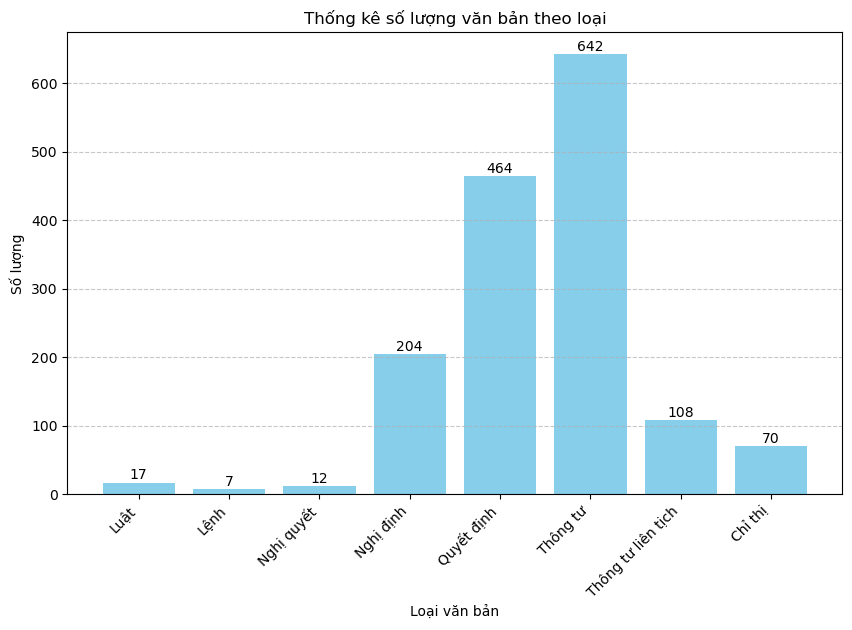

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

def show_num_doc(law_raw):
    # Bộ đếm số lượng từng loại văn bản
    counter = Counter()

    # Duyệt qua từng mục trong danh sách JSON
    for item in law_raw:
        title = item["metadata"]["title"]
        for doc_type in document_types:
            if doc_type in title:
                counter[doc_type] += 1
                break  # Đếm mỗi văn bản theo loại đầu tiên khớp

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.bar(counter.keys(), counter.values(), color="skyblue")
    plt.xlabel("Loại văn bản")
    plt.ylabel("Số lượng")
    plt.title("Thống kê số lượng văn bản theo loại")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Hiển thị số lượng trên cột
    for i, v in enumerate(counter.values()):
        plt.text(i, v + 5, str(v), ha="center", fontsize=10)

    plt.show()

show_num_doc(law_raw)

In [6]:
law_raw = [item for item in law_raw if "Lệnh" not in item["metadata"]["title"] and "Chỉ thị" not in item["metadata"]["title"]]

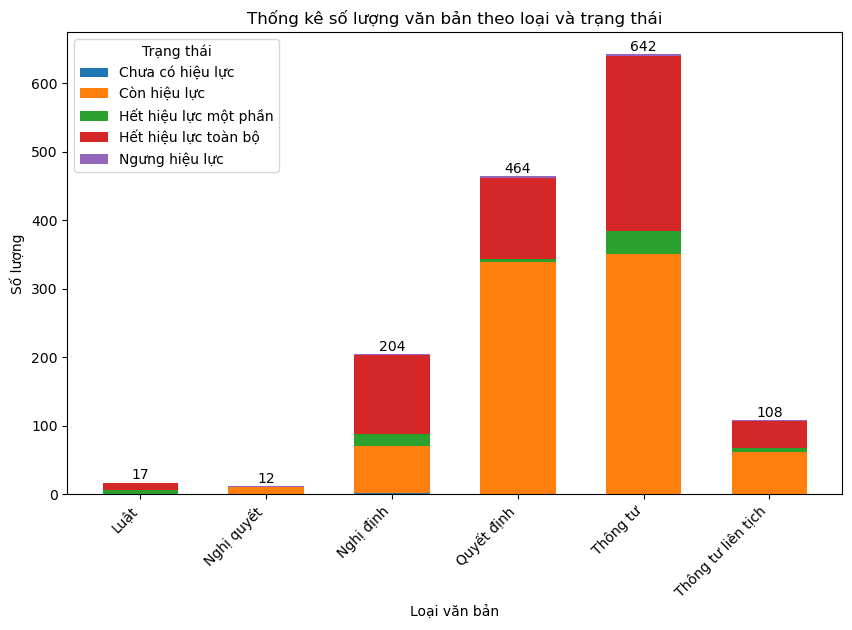

In [7]:

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter

# Bộ đếm số lượng từng loại văn bản theo status
doc_status_counts = defaultdict(Counter)

# Duyệt qua danh sách dữ liệu
for item in law_raw:
    title = item["metadata"]["title"]
    status = item["metadata"]["status"]

    for doc_type in document_types:
        if doc_type in title:
            doc_status_counts[doc_type][status] += 1
            break  # Chỉ tính theo loại đầu tiên khớp

# Danh sách các trạng thái hiệu lực
all_statuses = set()
for counts in doc_status_counts.values():
    all_statuses.update(counts.keys())
all_statuses = sorted(all_statuses)  # Đảm bảo thứ tự trạng thái

# Chuẩn bị dữ liệu vẽ biểu đồ
labels = list(doc_status_counts.keys())  # Các loại văn bản
status_data = {status: [doc_status_counts[doc].get(status, 0) for doc in labels] for status in all_statuses}

# Vẽ biểu đồ cột xếp chồng (stacked bar chart)
x = np.arange(len(labels))  # Tọa độ x
width = 0.6  # Độ rộng cột

fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(labels))  # Vị trí bắt đầu cho cột xếp chồng

for status in all_statuses:
    values = status_data[status]
    ax.bar(x, values, width, label=status, bottom=bottom)
    bottom += np.array(values)  # Cộng dồn cho phần tiếp theo

# Gán nhãn
ax.set_xlabel("Loại văn bản")
ax.set_ylabel("Số lượng")
ax.set_title("Thống kê số lượng văn bản theo loại và trạng thái")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend(title="Trạng thái")

# Hiển thị số lượng trên cột
for i in range(len(labels)):
    total = sum(status_data[status][i] for status in all_statuses)
    ax.text(i, total + 5, str(total), ha="center", fontsize=10, color="black")


plt.show()

In [8]:
from bs4 import BeautifulSoup

In [9]:
print(BeautifulSoup(law_raw[300]['html_data'], "html.parser").text.strip())

QUYẾT ĐỊNH

Về việc cử thành viên Ban Chỉ đạo Đổi mới và Phát triển doanh nghiệp

_________________________

THỦ TƯỚNG CHÍNH PHỦ

Căn cứ Luật Tổ chức Chính phủ ngày 25 tháng 12 năm 2001;

Căn cứ Quyết định số 1525/QĐ-TTg ngày 13 tháng 11 năm 2007 của Thủ tướng Chính phủ về việc điều chỉnh phân công người đứng đầu tổ chức phối hợp liên ngành do Thủ tướng Chính phủ thành lập;

Xét đề nghị của các Bộ: Tài chính, Kế hoạch và Đầu tư, Lao động – Thương binh và Xã hội, Nội vụ, Tư pháp và các cơ quan: Văn phòng Trung ương Đảng, Tổng Liên đoàn Lao động Việt Nam,

QUYẾT ĐỊNH:

Điều 1. Cử thành viên Ban Chỉ đạo Đổi mới và Phát triển doanh nghiệp như sau:

1. Trưởng ban: Phó Thủ tướng Thường trực Chính phủ Nguyễn Sinh Hùng.

2. Phó Trưởng ban Thường trực: Ông Phạm Viết Muôn, Phó Chủ nhiệm Văn phòng Chính phủ.

3. Các Ủy viên:

- Ông Trần Xuân Hà, Thứ trưởng Bộ Tài chính.

- Ông Trương Văn Đoan, Thứ trưởng Bộ Kế hoạch và Đầu tư.

- Ông Nguyễn Thanh Hòa, Thứ trưởng Bộ Lao động – Thương binh và Xã hộ

In [10]:
len(law_raw[300]['html_data'].split())

513

In [ ]:
import re

law_corpus = law_raw.copy()

for law in law_corpus:
    text = BeautifulSoup(law['html_data'], "html.parser").text.strip()
    text = re.sub(r'\n+\t*', ' \n ', text)
    law['data'] = re.sub(r'[ ]+', ' ', text)


In [40]:
law_corpus = [law for law in law_corpus if len(law['data']) > 10]

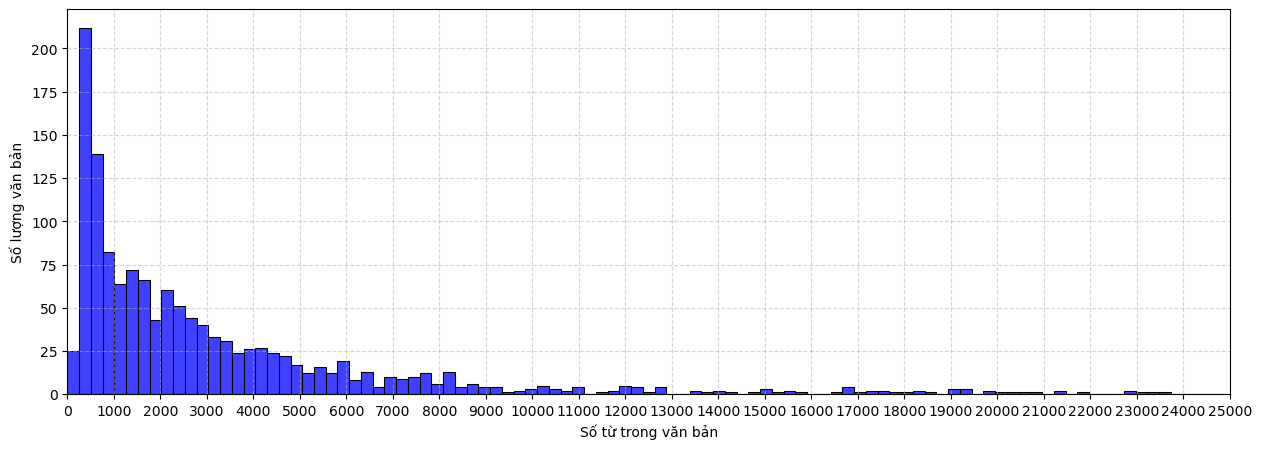

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


doc_lengths = []
for law in law_corpus:
    doc_lengths.append(len(law['data'].split(" ")))


bins = np.linspace(0, 25000, num=100)  

# Vẽ histogram
plt.figure(figsize=(15, 5))
sns.histplot(doc_lengths, bins=bins, kde=False, color="blue")

# Cấu hình biểu đồ
plt.xlim(0, 25000)
plt.xticks(np.arange(0, 25001, step=1000))
plt.xlabel("Số từ trong văn bản")
plt.ylabel("Số lượng văn bản")
plt.grid(True, linestyle="--", alpha=0.5)

# Hiển thị biểu đồ
plt.show()

In [44]:
max(doc_lengths)

246728

In [51]:
with open("Data\doc\law_corpus.json", "w", encoding="utf-8") as f:
    json.dump(law_corpus, f, indent=4, ensure_ascii=False)